## Problem:

Many of the text files contain a _tail_ of characters which are the result of the OCR engine trying to detect text at a 90 degree angle:

>IN THE SENATE OF THE UNITED STATES\
>April 11 (calendar day, April 13), 1932\
>Mr. TydIngs and Mr. Bingham introduced the following joint resolution;\
>**[...]**\
> and said laws shall continue to be in full force and effect in\
> the States which fail to ratify this article."\
> O	00 00\
> H-1	00\
> ct-	’l\
> p-	1 w\
> w	rt\
>	B\
> 1—	fB\
> o\
> a	e+\
> S’\
> P	a\
> O\
> w\
> T\
> S»\
> &\
> tr\
> w\
> §\
> *


## Solution:

The following procedure can be used to define a window that maximizes the probability of finding the cut-off point, which corresponds to the end of the amendment text.

#### Steps

1. We define a function based on the distribution of line lengths in the text (using character count as a proxy).


2. We smooth the curve to eliminate noise. For this we use the [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) filter to maximize preservation of the curves tendency. 


3. We adjust the size of the window for the moving average and the order of the polynomial equation based on the variance of the line-length distribution.


4. Next we use the second derivative of the curve to get the inflexion points. Although the curve of the distribution is non-parametric, we assume that it is twice differentiable, thus the inflexion points are those where the second derivative has an isolated zero and changes sign.

## Code:

In [45]:
import os
import regex as re # https://pypi.org/project/regex/
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import MeanShift, estimate_bandwidth
from IPython.core.interactiveshell import InteractiveShell

plt.style.use(['dark_background'])
InteractiveShell.ast_node_interactivity = "none"


In [2]:
# create a list of all files in the folder
samples_path = 'test_data/tails/'
samples = [f'{samples_path}{file.name}' for file in os.scandir(samples_path) if file.name != ".DS_Store"]


In [116]:
graph_data = []  # to store data to graph results

# iterate over the sample files
for path in samples:
    with open(path, 'r') as file:
        lines = file.readlines()  # load text as lines

    # Step 1: create a numpy array where each element is the count of 
    # characters in a line of the text
    dist = np.array([len(i) for i in lines])
    
    # Step 2: we use data from the distribution to optimize the parameters 
    # of the smoothing algorithm
    # we maximize the length of the filter window by mathing it to
    # the count of samples in the distribution, substracting 1 if the count
    # is an even number (interpolation requires the window length to be odd)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
    dist_size = len(dist)
    
    dist_2d = np.reshape(np.sort(dist), (-1, 1))  # make a 2D array from the distribution
    bandwidth = estimate_bandwidth(dist_2d, quantile=0.15)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)  # we use meanshift clustering with a flat kernel to identify clusters
    ms.fit(dist_2d)  # fit the data
    
    sample_low = np.sort(dist)[0]
    low_label = [i for i in range(len(np.unique(ms.labels_))) if sample_low in dist_2d[ms.labels_==i, 0]][0]
    low_cluster = dist_2d[ms.labels_==low_label, 0]
    tl = [i for i in dist.tolist()[round(len(dist)/2):] if i <= max(low_cluster)]
    ratio = round(len(tl)*100/dist_size, 2)
    
    win_factor = 11 if 25 <= ratio < 35 else 0    
    window_size = dist_size if dist_size % 2 != 0 else dist_size - 1
    window_size = window_size - win_factor
    
    # next we use the variance in the distribution to define the 
    # order of the polynomial used to fit the samples
    poly_order = 4 if ratio < 39 else 3
    
    # we generate the smoothed curve
    dist_smooth = savgol_filter(dist, window_size, poly_order)
    
    # Step 3: we calculate the second derivative of the smoothed curve
    second_deriv = np.gradient(np.gradient(dist_smooth))
    
    # Step 4: we extract the index of the rightmost inflexion point
    # which corresponds to both the x coordinate and the line number (1-based count)
    i_point_idx = np.max(np.where(np.diff(np.sign(second_deriv))))
    
    graph_data.append({
        'dist': dist,
        'smoothed': dist_smooth,
        'ip': i_point_idx,
        'filename': os.path.basename(path),
        'line_count': dist_size,
        'variance': variance,
        'poly_order': poly_order,
        'ratio': ratio,
        'wf': win_factor
    })


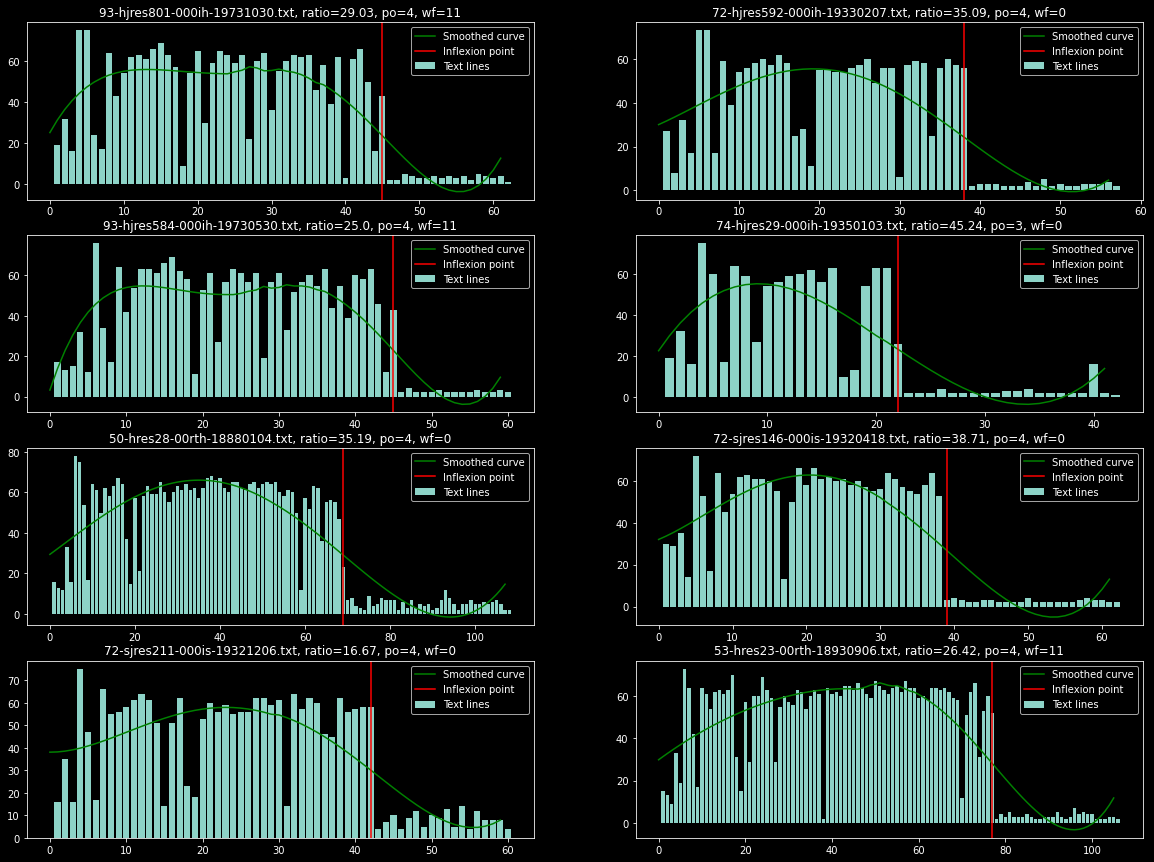

In [118]:
# plot the results 
plot_rows, plot_cols = 4, 2
current_row, current_col = 0, 0

fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(20, 15))

for idx, chart in enumerate(graph_data):
    ax = axs[current_row, current_col]
    ax.bar([i for i in range(1, chart['line_count']+1)], chart['dist'], label='Text lines')
    ax.plot(chart['smoothed'], label='Smoothed curve', color='green')
    ax.axvline(x=chart['ip'], color='red', label='Inflexion point')
    ax.legend()
    ax.title.set_text(f"{chart['filename']}, ratio={chart['ratio']}, po={chart['poly_order']}, wf={chart['wf']}")
    
    if current_col == (plot_cols - 1):
        current_row += 1
        current_col = 0
    else:
        current_col += 1
